<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture3/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RNNスクラッチ実装

### RNNユニットの実装

目的: 単純な RNN（Recurrent Neural Network）モデルの実装。

主な要件:

1. 入力層の次元数 (input_size) と隠れ層の次元数 (hidden_size) を引数として受け取る。
2. 入力層と隠れ層の重み行列とバイアスベクトルを保持する。
3. 重みとバイアスは、一様分布を $U\left(-\frac{1}{\text{hidden\_size}}, \frac{1}{\text{hidden\_size}}\right)$
 初期値として正規分布に従うランダムサンプルから生成。

4. forward メソッドを実装し、順伝搬の処理を行う。
5. 入力:
  * input: サイズが [batch_size, seq_len, input_size]
  * 初期隠れ状態 h_0: サイズが [1, batch_size, hidden_size]

6. 出力:
  * 全ステップの隠れ状態: [batch_size, seq_len, hidden_size]
  * 最後のステップの隠れ状態: [1, batch_size, hidden_size]

設計箇所

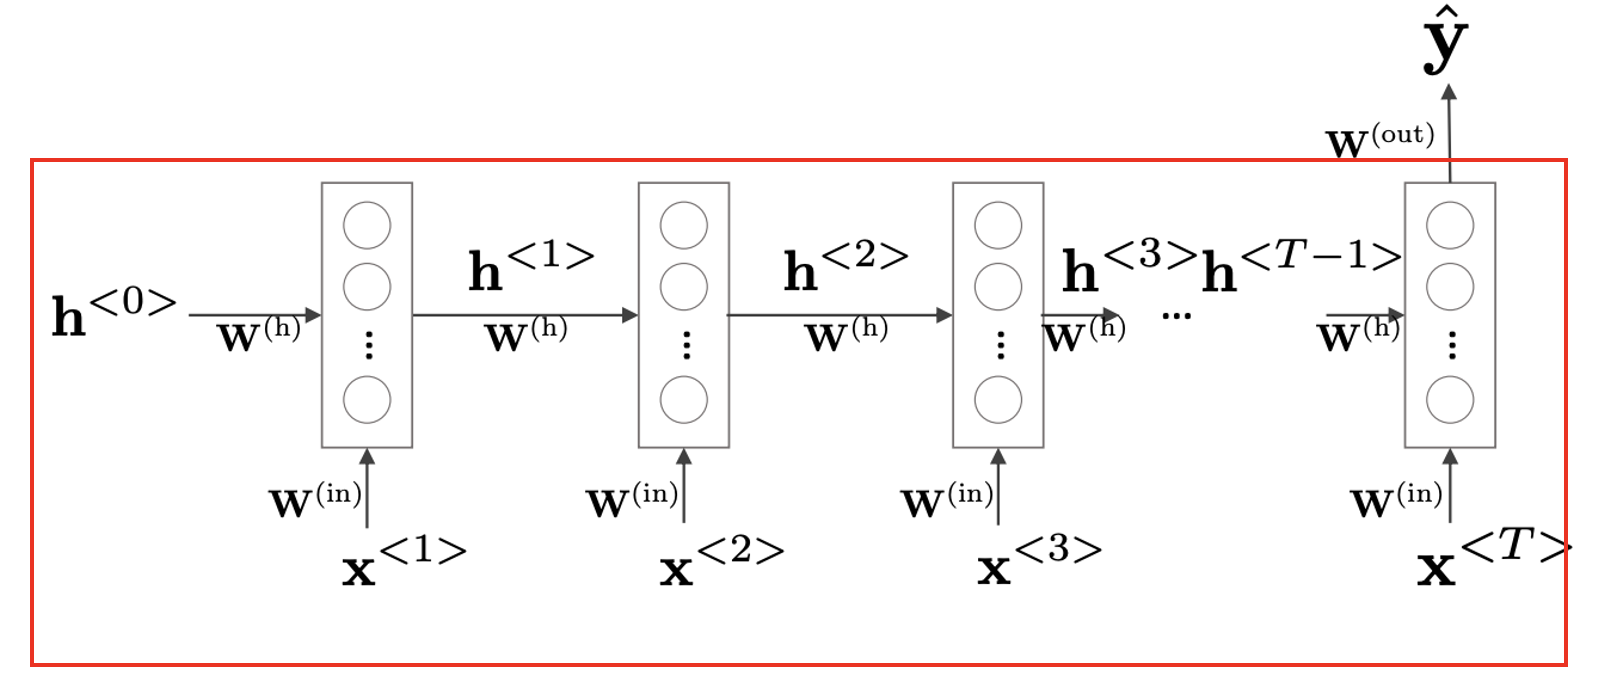

In [1]:
import torch
import math

In [2]:
class myRNN:
    def __init__(self, input_size, hidden_size):
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.W_in = torch.empty(hidden_size, input_size).uniform_(-1/hidden_size, 1/hidden_size)
        self.W_h = torch.empty(hidden_size, hidden_size).uniform_(-1/hidden_size, 1/hidden_size)

        self.b_in = torch.empty(hidden_size).uniform_(-1/hidden_size, 1/hidden_size)
        self.b_h = torch.empty(hidden_size).uniform_(-1/hidden_size, 1/hidden_size)

    def forward(self, input, h_0=None):
        # input（batch firstを想定）: [batch_size, seq_len, input_size]
        batch_size, seq_len, _ = input.size()

        if h_0 is None:
          h_0 = torch.zeros(1, batch_size, self.hidden_size).to("cpu")

        h = h_0 # [1, batch_size, hidden_size]
        outputs = []
        for i in range(seq_len):
            # [batch_size, hidden_size]
            h = torch.tanh(input[:, i]@self.W_in.T + h.squeeze(0)@self.W_h.T + self.b_in + self.b_h)
            outputs.append(h.unsqueeze(1)) # [batch_size, hidden_size] -> [batch_size, 1, hidden_size]
        output_seq = torch.cat(outputs, dim=1)
        h_n = h.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]

        return output_seq, h_n

In [3]:
input_size = 10
hidden_size = 3
batch_size = 8
seq_len = 5

# サンプルのTensor
sample = torch.randn(batch_size, seq_len, input_size)

In [4]:
rnn = myRNN(input_size, hidden_size)

In [5]:
sample.shape

torch.Size([8, 5, 10])

In [6]:
output_seq, h_n = rnn.forward(sample)

In [7]:
output_seq.shape

torch.Size([8, 5, 3])

### RNNモデルの実装

myRNNModel
* myRNNModelクラスを実装しよう
* 前回作成したmyRNNクラスと出力層(nn.Linear)を組み合わせる
* 新たに出力層の次元数(output_size)を引数として渡す
* forwardメソッドでは，最後の隠れ状態を出力層に入力し，最終的な結
果を返す
* （NERのようなケースでは，全ての隠れ状態を出力層に入力する）
* 最後の活性化関数は不要(通常pytorchの実装では損失関数に委ねる)

In [8]:
from torch import nn

In [9]:
class myRNNModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.rnn = myRNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, h_n = self.rnn.forward(x)
        # h_n: [1, batch_size, hidden_size]
        out = self.fc(h_n.squeeze(0))
        return out

In [10]:
output_size = 2 # ２クラス問題
model = myRNNModel(input_size, hidden_size, output_size)
out = model.forward(sample)
out.size()

torch.Size([8, 2])

### nn.RNN

pytorchが提供しているRNNを使用して設計する。

In [11]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, h_n = self.rnn(x)
        # output_seq: [batch_size, seq_len, hidden_size]
        # h_n: [1, batch_size, hidden_size]
        # out = self.fc(h_n.squeeze(0))
        out = self.fc(output_seq[:, -1, :]) #[batch_size, 1, hidden_size]
        # NER: (many to many)
        # out = self.fc(output_seq)
        return out

In [12]:
input_size = 10
hidden_size = 3
batch_size = 8
seq_len = 5
model = RNNModel(input_size, hidden_size, output_size)
out = model(sample)
out.size()

torch.Size([8, 2])

In [13]:
for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")

rnn.weight_ih_l0: torch.Size([3, 10])
rnn.weight_hh_l0: torch.Size([3, 3])
rnn.bias_ih_l0: torch.Size([3])
rnn.bias_hh_l0: torch.Size([3])
fc.weight: torch.Size([2, 3])
fc.bias: torch.Size([2])


### RNNの逆伝播

In [14]:
class myRNN:
    def __init__(self, input_size, hidden_size):
        self.hidden_size = hidden_size

        init_range = 1.0/math.sqrt(hidden_size)
        self.W_in = torch.empty(hidden_size, input_size).uniform_(-init_range, init_range).requires_grad_(True)
        self.W_h = torch.empty(hidden_size, hidden_size).uniform_(-init_range, init_range).requires_grad_(True)

        self.b_in = torch.empty(hidden_size).uniform_(-init_range, init_range).requires_grad_(True)
        self.b_h = torch.empty(hidden_size).uniform_(-init_range, init_range).requires_grad_(True)

    def forward(self, input, h_0=None):
        # input: [batch_size, seq_len, input_size]
        self.input = input
        self.h_0 = h_0
        batch_size, self.seq_len, _ = input.size()

        if h_0 is None:
            self.h_0 = torch.zeros(1, batch_size, self.hidden_size)#.to(device)

        h = self.h_0 # [1, batch_size, hidden_size]
        outputs = []
        for i in range(self.seq_len):
            # [batch_size, hidden_size]
            h = torch.tanh(input[:, i]@self.W_in.T + self.b_in + h.squeeze(0)@self.W_h.T + self.b_h)
            outputs.append(h.unsqueeze(1))# [batch_size, hidden_size] -> # [batch_size, 1, hidden_size]
        self.output_seq = torch.cat(outputs, dim=1)
        h_n = h.unsqueeze(0) # [batch_size, hidden_size] -> [1, batch_size, hidden_size]

        return self.output_seq, h_n

    def backward(self, out_grad):
        self.grad_W_in_list = []
        self.grad_W_h_list = []
        self.grad_b_in_list = []
        self.grad_b_h_list = []

        self.grad_h_list = []
        self.grad_h_tanh_list = []

        # 勾配の初期化
        grad_W_in = torch.zeros_like(self.W_in)
        grad_W_h = torch.zeros_like(self.W_h)
        grad_b_in = torch.zeros_like(self.b_in)
        grad_b_h = torch.zeros_like(self.b_h)
        grad_h = torch.zeros_like(self.h_0)

        # 各ステップの隠れ状態の勾配を初期化
        grad_output_seq = torch.zeros_like(self.output_seq)
        grad_output_seq[:, -1, :] = out_grad

        # 各ステップにおける勾配の計算
        for i in reversed(range(self.seq_len)):

          # tanhの微分 (dh*(1-dh^2))
          grad_h_tanh = grad_output_seq[:, i] * (1 - self.output_seq[:, i].pow(2))
          grad_W_in += torch.sum(grad_h_tanh.unsqueeze(2)*self.input[:,i].unsqueeze(1), dim=0)
          grad_b_in += torch.sum(grad_h_tanh, dim=0)
          grad_b_h += torch.sum(grad_h_tanh, dim=0)
          grad_h = grad_h_tanh @ self.W_h

          if i != 0:
              grad_output_seq[:, i-1] = grad_h
              # self.output_seqを使って計算
              grad_W_h += torch.sum(grad_h_tanh.unsqueeze(2)*self.output_seq[:, i-1].unsqueeze(1), dim=0)
          else:
              # h_0を使って計算
              grad_W_h += torch.sum(grad_h_tanh.unsqueeze(2)*self.h_0.squeeze(0).unsqueeze(1), dim=0)
          # 勾配を保持
          self.grad_W_in_list.append(grad_W_in.clone())
          self.grad_W_h_list.append(grad_W_h.clone())
          self.grad_b_in_list.append(grad_b_in.clone())
          self.grad_b_h_list.append(grad_b_h.clone())
          self.grad_h_list.append(grad_h.clone())
          self.grad_h_tanh_list.append(grad_h_tanh.clone())

class myRNNModel:
    def __init__(self, input_size, hidden_size, output_size):
        self.rnn = myRNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output_seq, self.h_n = self.rnn.forward(x)
        # output_seq: [batch_size, seq_len, hidden_size]
        # h_n: [1, batch_size, hidden_size]
        out = self.fc(self.h_n.squeeze(0))
        return out

In [15]:
# backwardのテスト
input_size = 3
hidden_size = 2
batch_size = 3
seq_len = 5

# 入力データと正解ラベルの定義
input_tensor = torch.randn(batch_size, seq_len, input_size)
target = torch.tensor([0]*batch_size)

# モデルのインスタンス作成
model = myRNNModel(input_size, hidden_size, output_size)
# forward
output = model.forward(input_tensor)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()
# 損失計算
loss = criterion(output, target)
# 出力層の勾配計算
out_grad = torch.autograd.grad(loss, model.h_n, retain_graph=True)[0]
# スクラッチのbackward
model.rnn.backward(out_grad)
# autograd
loss.backward()

print("Autograd Gradient - W_in:", model.rnn.W_in.grad)
print("Manual Gradient - W_in:", model.rnn.grad_W_in_list[-1])
print("======================")
print("Autograd Gradient - W_h:", model.rnn.W_h.grad)
print("Manual Gradient - W_h:", model.rnn.grad_W_h_list[-1])
print("======================")
print("Autograd Gradient - b_in:", model.rnn.b_in.grad)
print("Manual Gradient - b_in:", model.rnn.grad_b_in_list[-1])
print("======================")
print("Autograd Gradient - b_h:", model.rnn.b_h.grad)
print("Manual Gradient - b_h:", model.rnn.grad_b_h_list[-1])

Autograd Gradient - W_in: tensor([[ 0.0464,  0.0205, -0.0106],
        [ 0.0116,  0.0813,  0.1065]])
Manual Gradient - W_in: tensor([[ 0.0464,  0.0205, -0.0106],
        [ 0.0116,  0.0813,  0.1065]], grad_fn=<CloneBackward0>)
Autograd Gradient - W_h: tensor([[-0.0188,  0.0016],
        [-0.0040, -0.0134]])
Manual Gradient - W_h: tensor([[-0.0188,  0.0016],
        [-0.0040, -0.0134]], grad_fn=<CloneBackward0>)
Autograd Gradient - b_in: tensor([0.0208, 0.1170])
Manual Gradient - b_in: tensor([0.0208, 0.1170], grad_fn=<CloneBackward0>)
Autograd Gradient - b_h: tensor([0.0208, 0.1170])
Manual Gradient - b_h: tensor([0.0208, 0.1170], grad_fn=<CloneBackward0>)


**外積の計算例**

In [16]:
a = torch.tensor([[1, 2], [3, 4], [5, 6]])
b = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [17]:
a

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [18]:
b

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

In [19]:
# リスト内包表記で一つずつ処理
outer_product_list  = [torch.ger(a_row, b_row) for a_row, b_row in zip(a, b)]
outer_product_list

[tensor([[1, 2, 3],
         [2, 4, 6]]),
 tensor([[12, 15, 18],
         [16, 20, 24]]),
 tensor([[35, 40, 45],
         [42, 48, 54]])]

In [20]:
a = torch.randn(1, 3)

In [21]:
a.shape

torch.Size([1, 3])

In [22]:
a.squeeze(0).shape

torch.Size([3])

In [23]:
a.shape

torch.Size([1, 3])